In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten,BatchNormalization,Dropout,GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import pickle
import random
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam

In [2]:
def augment_image(img):
    augmented_images = []

    # 1. Flip Horizontally
    flipped = cv2.flip(img, 1)
    augmented_images.append(flipped)

    # 2. Rotate (-30 to +30 degrees)
    angle = random.uniform(-30, 30)
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((w//2, h//2), angle, 1)
    rotated = cv2.warpAffine(img, M, (w, h))
    augmented_images.append(rotated)

    # 3. Adjust Brightness
    # brightness_factor = random.uniform(0.7, 1.3)
    # bright = np.clip(img * brightness_factor, 0, 255).astype(np.uint8)
    # augmented_images.append(bright)

    # 4. Add Gaussian Noise
    # noise = np.random.normal(0, 10, img.shape).astype(np.uint8)
    # noisy = cv2.add(img, noise)
    # augmented_images.append(noisy)

    return augmented_images

In [3]:
#Train Data
train_dataset_path = ["dataset/Rice_Leaf_Diease/train/bacterial_leaf_blight","dataset/Rice_Leaf_Diease/train/brown_spot","dataset/Rice_Leaf_Diease/train/healthy",
                      "dataset/Rice_Leaf_Diease/train/leaf_blast","dataset/Rice_Leaf_Diease/train/leaf_scald","dataset/Rice_Leaf_Diease/train/narrow_brown_spot",
                      "dataset/Rice_Leaf_Diease/train/neck_blast","dataset/Rice_Leaf_Diease/train/rice_hispa","dataset/Rice_Leaf_Diease/train/sheath_blight",
                      "dataset/Rice_Leaf_Diease/train/tungro"]
label = ["bacterial_leaf_blight","brown_spot","healthy","leaf_blast","leaf_scald","narrow_brown_spot","neck_blast","rice_hispa","sheath_blight","tungro",]
train_images_list = []
train_labels_list = []

for i, path in enumerate(train_dataset_path):
    if not os.path.exists(path):
        print(f"Error: Directory not found - {path}")
        continue  # Skip this folder if it doesn't exist

    dir_list = os.listdir(path)
    for img_name in dir_list:
        input_path = os.path.join(path, img_name)

        # Read image
        img = cv2.imread(input_path)
        if img is None:
            print(f"Warning: Could not read image {input_path}")
            continue  # Skip invalid images

        # Convert BGR to RGB
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Resize to a fixed size (128x128)
        img_rgb = cv2.resize(img_rgb, (128, 128))

        # Append original image
        train_images_list.append(img_rgb)
        train_labels_list.append(label[i])

        # Apply augmentations and add to dataset
        #augmented_images = augment_image(img_rgb)
        # for aug_img in augmented_images:
        #     train_images_list.append(aug_img)
        #     train_labels_list.append(label[i])

# Convert lists to NumPy arrays for training
X = np.array(train_images_list)
y = np.array(train_labels_list)

print(f"Dataset size for Training: {len(X)} images")

Dataset size for Training: 15023 images


In [4]:
#Validation Data
test_dataset_path = ["dataset/Rice_Leaf_Diease/test/bacterial_leaf_blight","dataset/Rice_Leaf_Diease/test/brown_spot","dataset/Rice_Leaf_Diease/test/healthy",
                      "dataset/Rice_Leaf_Diease/test/leaf_blast","dataset/Rice_Leaf_Diease/test/leaf_scald","dataset/Rice_Leaf_Diease/test/narrow_brown_spot",
                      "dataset/Rice_Leaf_Diease/test/neck_blast","dataset/Rice_Leaf_Diease/test/Rice Hispa","dataset/Rice_Leaf_Diease/test/Sheath Blight",
                      "dataset/Rice_Leaf_Diease/test/tungro"]
# label = ["bacterial_leaf_blight","brown_spot","healthy","leaf_blast","leaf_scald","narrow_brown_spot","neck_blast","rice_hispa","sheath_blight","tungro",]
test_images_list = []
test_labels_list = []

for i, path in enumerate(test_dataset_path):
    if not os.path.exists(path):
        print(f"Error: Directory not found - {path}")
        continue  # Skip this folder if it doesn't exist

    dir_list = os.listdir(path)
    for img_name in dir_list:
        input_path = os.path.join(path, img_name)

        # Read image
        img = cv2.imread(input_path)
        if img is None:
            print(f"Warning: Could not read image {input_path}")
            continue  # Skip invalid images

        # Convert BGR to RGB
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Resize to a fixed size (128x128)
        img_rgb = cv2.resize(img_rgb, (128, 128))

        # Append original image
        test_images_list.append(img_rgb)
        test_labels_list.append(label[i])

# Convert lists to NumPy arrays for Validation
Validation_image = np.array(test_images_list)
Validation_label = np.array(test_labels_list)

print(f"Dataset size for Validation: {len(Validation_image)} images")

Dataset size for Validation: 3422 images


In [5]:
# Generate a dictionary with images split into categories
image_label_dict = {}
for l in label:
    image_label_dict[l] = [train_images_list[i] for i, x in enumerate(train_labels_list) if x == l]

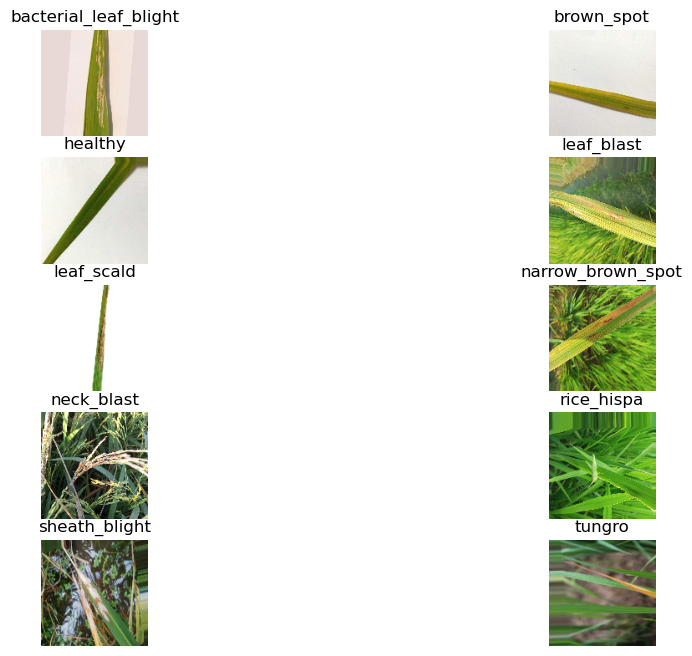

In [6]:
# Plot images
plt.figure(figsize=(12, 8))

for i, l in enumerate(label):
    if len(image_label_dict[l]) > 0:  # Ensure there's at least one image
        plt.subplot(5, 2, i + 1)
        plt.imshow(image_label_dict[l][0])
        plt.axis('off')
        plt.title(l)

plt.show()

In [7]:
print("Dictionary Keys:", image_label_dict.keys())
print("Labels List:", label)

Dictionary Keys: dict_keys(['bacterial_leaf_blight', 'brown_spot', 'healthy', 'leaf_blast', 'leaf_scald', 'narrow_brown_spot', 'neck_blast', 'rice_hispa', 'sheath_blight', 'tungro'])
Labels List: ['bacterial_leaf_blight', 'brown_spot', 'healthy', 'leaf_blast', 'leaf_scald', 'narrow_brown_spot', 'neck_blast', 'rice_hispa', 'sheath_blight', 'tungro']


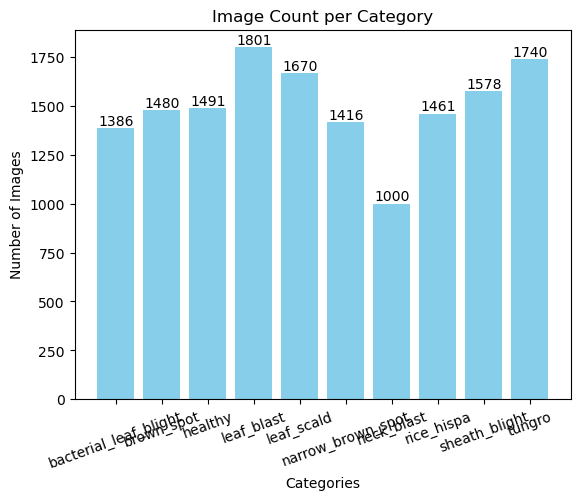

In [8]:
# Count the number of images per category
image_counts = [len(image_label_dict[l]) for l in label]

# Create bar chart
fig, ax = plt.subplots()
bars = ax.bar(label, image_counts, color='skyblue')

# Add labels on bars
ax.bar_label(bars)

# Improve visualization
ax.set_ylabel("Number of Images")
ax.set_xlabel("Categories")
ax.set_title("Image Count per Category")
plt.xticks(rotation=20)  # Rotate labels if needed
plt.show()

before Augumentation
[1584, 1440, 1600, 1308]

In [9]:
image_counts

[1386, 1480, 1491, 1801, 1670, 1416, 1000, 1461, 1578, 1740]

In [10]:
# Define class labels
classes = np.array([0, 1, 2, 3,4,5,6,7,8,9])  # Assuming 4 classes

# Define the labels for each image (list of actual class labels)
labels = np.concatenate([
    np.full(1386, 0),  # 4752 images of class 0
    np.full(1480, 1),  # 4320 images of class 1
    np.full(1491, 2),  # 4800 images of class 2
    np.full(1801, 3),   # 3924 images of class 3
    np.full(1670, 4),    #4464 images of class 4
    np.full(1416,5),
    np.full(1000,6),
    np.full(1461,7),
    np.full(1578,8),
    np.full(1740,9),
])

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=labels)

# Convert to dictionary format
class_weight_dict = {i: w for i, w in enumerate(class_weights)}

print(class_weight_dict)

{0: 1.083910533910534, 1: 1.0150675675675676, 2: 1.0075788061703554, 3: 0.8341476957245975, 4: 0.8995808383233533, 5: 1.0609463276836157, 6: 1.5023, 7: 1.028268309377139, 8: 0.9520278833967047, 9: 0.8633908045977011}


In [11]:
# Step 1: Convert to NumPy array
images_array = np.array([cv2.resize(img, (128, 128)) for img in train_images_list])  # Resize to 128x128
images_array = images_array / 255.0  # Normalize pixel values

# Step 2: Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(train_labels_list)  # Convert text labels to numbers
labels_encoded = to_categorical(labels_encoded, num_classes= 10)

In [12]:
# Step 1: Convert to NumPy array
Validation_image = np.array([cv2.resize(img, (128, 128)) for img in Validation_image])  # Resize to 128x128
Validation_image = Validation_image / 255.0  # Normalize pixel values

# Step 2: Encode labels
label_encoder = LabelEncoder()
Validation_label = label_encoder.fit_transform(Validation_label)  # Convert text labels to numbers
Validation_label = to_categorical(Validation_label, num_classes= 10)

In [13]:
x_train, x_test, y_train, y_test = train_test_split(images_array, labels_encoded, test_size = 0.2, random_state = 42)

In [14]:
print("Length of original set: ", images_array.shape, "y:", labels_encoded.shape)
print("Length of train set: ", x_train.shape, "y:", y_train.shape)
print("Length of test set: ", x_test.shape, "y:", y_test.shape)

Length of original set:  (15023, 128, 128, 3) y: (15023, 10)
Length of train set:  (12018, 128, 128, 3) y: (12018, 10)
Length of test set:  (3005, 128, 128, 3) y: (3005, 10)


In [15]:
# Load the VGG16 model without the top layers
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(128, 128, 3))

In [16]:
# Freeze the convolutional base
base_model.trainable = False

In [ ]:
# Define the new model
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D()) 
model.add(Dense(4096, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(2048, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(1024, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(10, activation="softmax"))  # 10 classes

In [18]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

In [19]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │     2,101,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2048)           │     8,390,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │        10,250 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 27,315,018 (104.20 MB)

 Trainable params: 12,600,330 (48.07 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [20]:
hist = model.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test), batch_size=16, class_weight=class_weight_dict)

Epoch 1/10
752/752 ━━━━━━━━━━━━━━━━━━━━ 1277s 2s/step - accuracy: 0.4435 - loss: 1.5338 - val_accuracy: 0.6609 - val_loss: 0.9550
Epoch 2/10
752/752 ━━━━━━━━━━━━━━━━━━━━ 1235s 2s/step - accuracy: 0.6944 - loss: 0.8130 - val_accuracy: 0.7671 - val_loss: 0.6535
Epoch 3/10
752/752 ━━━━━━━━━━━━━━━━━━━━ 1252s 2s/step - accuracy: 0.7822 - loss: 0.5914 - val_accuracy: 0.7870 - val_loss: 0.5983
Epoch 4/10
752/752 ━━━━━━━━━━━━━━━━━━━━ 1250s 2s/step - accuracy: 0.8242 - loss: 0.4715 - val_accuracy: 0.8273 - val_loss: 0.4742
Epoch 5/10
752/752 ━━━━━━━━━━━━━━━━━━━━ 1249s 2s/step - accuracy: 0.8516 - loss: 0.3814 - val_accuracy: 0.8489 - val_loss: 0.4337
Epoch 6/10
752/752 ━━━━━━━━━━━━━━━━━━━━ 1258s 2s/step - accuracy: 0.8735 - loss: 0.3375 - val_accuracy: 0.8656 - val_loss: 0.3590
Epoch 7/10
752/752 ━━━━━━━━━━━━━━━━━━━━ 1257s 2s/step - accuracy: 0.8895 - loss: 0.2804 - val_accuracy: 0.8802 - val_loss: 0.3309
Epoch 8/10
752/752 ━━━━━━━━━━━━━━━━━━━━ 1191s 2s/step - accuracy: 0.9149 - loss: 0.2207 - 

In [21]:
loss, acc = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {acc * 100:.2f}%")
print(f"loss: {loss * 100:.2f}%")

94/94 ━━━━━━━━━━━━━━━━━━━━ 246s 3s/step - accuracy: 0.8989 - loss: 0.2864
Test Accuracy: 89.68%
loss: 29.96%


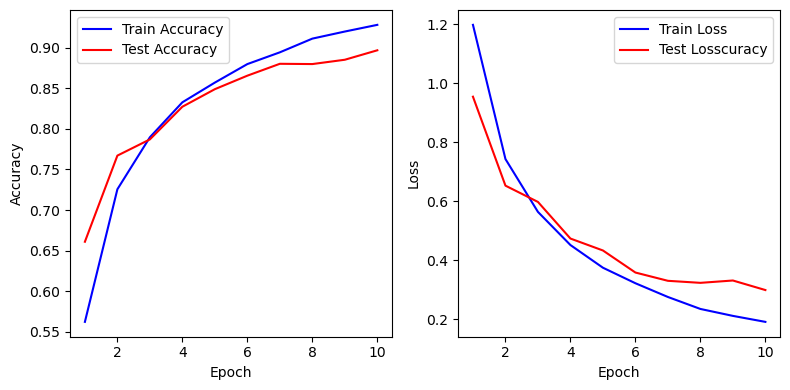

In [22]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs = range(1,len(acc) + 1)
#Creating subplots
fig,axes = plt.subplots(nrows = 1, ncols = 2, figsize = (8,4))
axes[0].plot(epochs, acc, 'b', label = 'Train Accuracy')
axes[0].plot(epochs, val_acc, 'r', label = 'Test Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()

axes[1].plot(epochs, loss, 'b', label = 'Train Loss')
axes[1].plot(epochs, val_loss, 'r', label = 'Test Losscuracy')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()

#Adjust layout for better spacing
plt.tight_layout()
#display figure
plt.show()

In [23]:
y_pred = model.predict(x_test)

94/94 ━━━━━━━━━━━━━━━━━━━━ 252s 3s/step


In [24]:
y_test = np.argmax(y_test, axis=1)
y_pred = np.argmax(y_pred, axis=1)
report = classification_report(y_test,y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.97      0.96      0.97       275
           1       0.85      0.73      0.79       295
           2       0.78      0.92      0.84       331
           3       0.89      0.69      0.78       339
           4       0.95      0.96      0.96       329
           5       0.83      0.83      0.83       302
           6       1.00      0.99      1.00       198
           7       0.91      0.97      0.94       289
           8       0.84      0.97      0.90       315
           9       0.99      0.99      0.99       332

    accuracy                           0.90      3005
   macro avg       0.90      0.90      0.90      3005
weighted avg       0.90      0.90      0.90      3005



In [25]:
print(confusion_matrix(y_pred,y_test))

[[264   3   0   0   2   1   0   0   1   0]
 [  0 215   9  26   0   2   0   0   0   0]
 [  0  33 304  33   0   7   0   8   5   0]
 [  0   6   4 235   1  14   0   0   1   3]
 [  5   1   0   5 315   3   1   0   0   0]
 [  3  34   1  11   1 252   0   0   0   0]
 [  0   0   0   0   0   0 197   0   0   0]
 [  3   0   9   4   1   6   0 280   3   1]
 [  0   3   4  24   8  17   0   1 305   0]
 [  0   0   0   1   1   0   0   0   0 328]]


In [26]:
val_loss, val_acc = model.evaluate(Validation_image, Validation_label)
print(f"Test Accuracy: {val_acc * 100:.2f}%")
print(f"loss: {val_loss * 100:.2f}%")

107/107 ━━━━━━━━━━━━━━━━━━━━ 270s 3s/step - accuracy: 0.8644 - loss: 0.4453
Test Accuracy: 85.33%
loss: 54.16%


In [27]:
val_y_pred = model.predict(Validation_image)

107/107 ━━━━━━━━━━━━━━━━━━━━ 257s 2s/step


In [28]:
val_y_test = np.argmax(Validation_label, axis=1)
val_y_pred = np.argmax(val_y_pred, axis=1)
val_report = classification_report(val_y_test,val_y_pred)
print(val_report)

              precision    recall  f1-score   support

           0       0.97      0.96      0.96       376
           1       0.82      0.74      0.78       380
           2       0.69      0.91      0.78       391
           3       0.90      0.69      0.78       362
           4       0.96      0.91      0.93       386
           5       0.82      0.89      0.86       382
           6       1.00      1.00      1.00       322
           7       0.85      0.60      0.71       225
           8       0.70      0.75      0.73       288
           9       0.91      0.98      0.94       310

    accuracy                           0.85      3422
   macro avg       0.86      0.84      0.85      3422
weighted avg       0.86      0.85      0.85      3422



In [29]:
print(confusion_matrix(val_y_pred,val_y_test))

[[361   4   2   0   2   0   0   0   4   0]
 [  0 282  10  31   4  12   0   1   4   0]
 [  1  23 357  55   6   8   0  44  25   0]
 [  0   9   5 250   0   4   0   2   8   1]
 [  4   1   0   3 351   3   0   0   4   1]
 [  7  47   0   9   2 340   0   0   5   3]
 [  0   0   1   0   0   0 322   0   0   0]
 [  3   1   4   1   3   1   0 136  10   1]
 [  0  12  12  11  14  12   0  32 217   0]
 [  0   1   0   2   4   2   0  10  11 304]]


In [30]:
pickle_out = open("modelv10.pkl", "wb")
pickle.dump(model, pickle_out)
pickle_out.close()